# Convolutional AutoEncoder model for anomalies detection

In [76]:
# ---- utils libs ----
import numpy as np
import pandas as pd
import datetime
from typing import Optional

# --- Import functions from module.py ---
import sys
sys.path.insert(0,'..')
from module import plot_confusion_matrix, plot_activity_hist, load_dataset, load_aggregate_dataset, time_in_range, segmentDf, create_sequence, train_test_split_dataset, convertToSequenceParameters, score_overlap, load_aggregate_dataset

# ---- Data Viz libs ---- 
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# ---- ML libs ----
from sklearn.preprocessing import StandardScaler

# ---- Deep Learning libs ----
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

## Preprocessing

####  1/ Loads the dataset and resample timeseries
####  2/ Split a dataframe into train set and test set according to the split rate
####  3/ Standardize Data
####  4/ Construction of the dataset according to peak and off-peak hours or according to activity labels
####  5/ Creation of sequences of length T and according to the overlapping period

#### Return preprocessed ``3D-array`` ``[samples, SEQUENCE_LENGTH, features]`` (i.e sequences from the timeseries) , as required for **LSTM** network. We want our network to have memory of **10 days**, so we set ``SEQUENCE_LENGTH=10``.

#### Define Global Hyperparmètre

In [77]:
TIME_STEP = datetime.timedelta(minutes=1, seconds=30) # duration of a step in the resample dataset, originally 1 second
DURATION_TIME = datetime.timedelta(minutes=60) # duration of a sequence
OVERLAP_PERIOD_PERCENT = 0.8 # 0.5 <=> 50% overlapping
TIMEFRAMES = [(datetime.time(0,0,0), datetime.time(3,0,0))]
STRATEGY = "off_peak_time" # device, off_peak_time, label
STRATEGY_FT = "off_peak_time" # device, off_peak_time, label 

SEQUENCE_LENGTH, OVERLAP_PERIOD = convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)

print("\t\tValeur choisie \t Equivalent sequence\nTimestep : \t {}\nDuration :\t {} \t -->  {} \nOverlap :\t {} \t\t -->  {}".format(TIME_STEP, DURATION_TIME, SEQUENCE_LENGTH, OVERLAP_PERIOD_PERCENT, OVERLAP_PERIOD))

LEARNING_RATE = 0.001
LEARNING_RATE_FT = 0.0001

NITER = 50
NITER_FT = 100

LAYERS_FT = 0,2

		Valeur choisie 	 Equivalent sequence
Timestep : 	 0:01:30
Duration :	 1:00:00 	 -->  40 
Overlap :	 0.8 		 -->  32


In [78]:
def preprocessing(timeframes: list
                  ,sequence_length: int, overlap_period: int
                  ,resample_period :Optional[str]=None
                  ,use_labels :Optional[bool]=False
                  ,strategy :Optional[str] = "off_peak_time" 
                  ,split_rate :Optional[float]=0.2
                  ,dataset_name:Optional[str] = "house1_power_blk2_labels.zip") -> np.array:
    """
    1/ Loads the dataset and resample timeseries
    2/ Split a dataframe into train set and test set according to the split rate
    3/ Standardize Data
    4/ Construction of the dataset according to peak and off-peak hours 
    or according to activity labels
    5/ Creation of sequences of length T and according to the overlapping period
    
    Args:
        - resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
        - timeframes: list of tuples indicating the periods of the day ex: timeframes = [(datetime.time(10,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))
        - use_labels: (False by default) use the activities labels
        - sequence_length: length of the sequence
        - overlap_period: overlap the sequences of timeseries
        - device_approach: the aggregated load curve of the devices which, when in operation, do not allow us to predict an activity 
        - split_rate: Rate of the test set size
        - device_strategy: use inactive devices base load curve
        - dataset_name: the name of the dataset file to use
    Returns: 
        - list of prepocessed 3D-array [samples, sequence_length, features] (i.e sequences from the timeseries) 
    """

    # load dataset with labels and resampled timeseries
    df_resampled = load_dataset(dataset_name, resample_period)
    house = dataset_name.split('_')[0]
    if house == 'house1': # [ 1, 2, 3, 4, 5, 6, 9, 10, 17, 18, 19] # 20,21,24
        corrected_mains = load_aggregate_dataset("house1_power_blk2.zip", sub_panels=[f'sub{i}' for i in list(set(range(1, 25)) - {13})], resample_period=resample_period)
        df_resampled['mains'] = corrected_mains['mains']

    # split dataframe into train set and test set
    train_df, test_df = train_test_split_dataset(df_resampled)
    
    # Standardize Data
    scaler = StandardScaler() # MinMaxScaler()
    scaler_train = scaler.fit(train_df[['mains']])
    
    train_df['mains'] = scaler_train.transform(train_df[['mains']])
    test_df['mains'] = scaler_train.transform(test_df[['mains']])
        
    # ---- TEST SEQUENCES ----
    X_sequences_test, y_sequences_test = create_sequence(test_df, sequence_length, overlap_period)
    
    if strategy == "device":
        # load dataset with labels and resampled timeseries
        #df_resampled_with_labels = load_dataset(dataset_name, resample_period)
        # load dataset with inactive devices
        blk = "blk2" if house[-1] == "1" else "blk1"
        df_resampled_devices_inactive = load_aggregate_dataset(house+"_power_"+blk+".zip", "inactive_"+house, resample_period)
        df_resampled_device = df_resampled_devices_inactive.join(df_resampled["activity"])
        df_resampled_device['mains'] = scaler_train.transform(df_resampled_device[['mains']])
        
        # --- TRAIN SEQUENCES ----
        X_sequence_train_device, y_sequence_train_device = create_sequence(df_resampled_device, sequence_length, overlap_period)
        
        return df_resampled_device, test_df, X_sequence_train_device, y_sequence_train_device, X_sequences_test, y_sequences_test
    
    
    if strategy == "label":
        # load dataset with labels and resampled timeseries
        #df_resampled_with_labels = load_dataset(dataset_name, resample_period)#.rolling('30min').mean()
        #df_resampled_with_labels['activity'] = (df_resampled_with_labels['activity'] > 0).astype(int)
        #df_resampled_with_labels = df_resampled_with_labels[df_resampled_with_labels['activity'] == 0]
        #df_resampled_with_labels['mains'] = scaler_train.transform(df_resampled_with_labels[['mains']])
        train_df['activity'] = (train_df['activity'].rolling('30min').mean() > 0).astype(int)
        # --- TRAIN SEQUENCES ----
        X_sequence_train_label, y_sequence_train_label = create_sequence(train_df[train_df['activity'] == 0], sequence_length, overlap_period)
        
        return train_df[train_df['activity'] == 0], test_df, X_sequence_train_label, y_sequence_train_label, X_sequences_test, y_sequences_test
    
    if strategy == "off_peak_time":
        # --- TRAIN SEQUENCES ----
        # Construction of the dataset according to peak and off-peak hours 
        list_df_train = segmentDf(train_df, timeframes=timeframes)

        # init 3D-array [samples, sequence_length, features]
        first_df_train = list_df_train[0]
        list_X_sequence_train, list_y_sequence_train = create_sequence(first_df_train, sequence_length, overlap_period)
        list_df_train.pop(0) # delete the first element of the list of train dataframes

        # Creation of sequences of length T and according to the overlapping period
        for df_train_ in list_df_train:
            X_sequences_train, y_sequences_train = create_sequence(df_train_, sequence_length, overlap_period)
            list_X_sequence_train = np.append(list_X_sequence_train, X_sequences_train, axis = 0)
            list_y_sequence_train = np.append(list_y_sequence_train, y_sequences_train, axis = 0)
        
        return list_df_train, train_df, test_df, list_X_sequence_train, list_y_sequence_train, X_sequences_test, y_sequences_test

    if strategy == "device_off_peak_time":
        # --- TRAIN SEQUENCES ----
        blk = "blk2" if house[-1] == "1" else "blk1"
        df_resampled_devices_inactive = load_aggregate_dataset(house+"_power_"+blk+".zip", "inactive_"+house, resample_period)
        df_resampled_device = df_resampled_devices_inactive.join(df_resampled["activity"])
        df_resampled_device['mains'] = scaler_train.transform(df_resampled_device[['mains']])

        # Construction of the dataset according to peak and off-peak hours 
        list_df_train = segmentDf(df_resampled_device, timeframes=timeframes)

        # init 3D-array [samples, sequence_length, features]
        first_df_train = list_df_train[0]
        list_X_sequence_train, list_y_sequence_train = create_sequence(first_df_train, sequence_length, overlap_period)
        list_df_train.pop(0) # delete the first element of the list of train dataframes

        # Creation of sequences of length T and according to the overlapping period
        for df_train_ in list_df_train:
            X_sequences_train, y_sequences_train = create_sequence(df_train_, sequence_length, overlap_period)
            list_X_sequence_train = np.append(list_X_sequence_train, X_sequences_train, axis = 0)
            list_y_sequence_train = np.append(list_y_sequence_train, y_sequences_train, axis = 0)
        
        return list_df_train, train_df, test_df, list_X_sequence_train, list_y_sequence_train, X_sequences_test, y_sequences_test

In [79]:
if STRATEGY == "device":
    resampled_device_train_df_h1, test_df_h1, X_train_h1, y_train_h1, X_test_h1, y_test_h1 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house1_power_blk2_labels.zip")

    resampled_device_train_df_h2, test_df_h2, X_train_h2, y_train_h2, X_test_h2, y_test_h2 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")
    
if STRATEGY == "label":
    resampled_label_train_df_h1, test_df_h1, X_train_h1, y_train_h1, X_test_h1, y_test_h1 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house1_power_blk2_labels.zip")

    resampled_label_train_df_h2, test_df_h2, X_train_h2, y_train_h2, X_test_h2, y_test_h2 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")
    
if STRATEGY == "off_peak_time" or STRATEGY == "device_off_peak_time":
    list_df_train_h1, train_df_h1, test_df_h1, X_train_h1, y_train_h1, X_test_h1, y_test_h1 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house1_power_blk2_labels.zip")
    list_df_train_h2, train_df_h2, test_df_h2, X_train_h2, y_train_h2, X_test_h2, y_test_h2 = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")

/tmp/ipykernel_211591/2082496867.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_211591/2082496867.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mnt/data/Documents/Cours Télécom/INFMDI780 - Projet Fil Rouge/Activity_Detection_From_Electrical_Consumption_Load_Curves/Convolutional Auto Encoder/../module.py:453: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [80]:
if STRATEGY_FT == "device":
    resampled_device_train_df_h1_ft, test_df_h1_ft, X_train_h1_ft, y_train_h1_ft, X_test_h1_ft, y_test_h1_ft = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY_FT
                              ,dataset_name="house1_power_blk2_labels.zip")

    resampled_device_train_df_h2_ft, test_df_h2_ft, X_train_h2_ft, y_train_h2_ft, X_test_h2_ft, y_test_h2_ft = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")
    
if STRATEGY_FT == "label":
    resampled_label_train_df_h1_ft, test_df_h1_ft, X_train_h1_ft, y_train_h1_ft, X_test_h1_ft, y_test_h1_ft = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY_FT
                              ,dataset_name="house1_power_blk2_labels.zip")

    resampled_label_train_df_h2_ft, test_df_h2_ft, X_train_h2_ft, y_train_h2_ft, X_test_h2_ft, y_test_h2_ft = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY
                              ,dataset_name="house2_power_blk1_labels.zip")
    
if STRATEGY_FT == "off_peak_time" or STRATEGY_FT == "device_off_peak_time":
    list_df_train_h1_ft, train_df_h1_ft, test_df_h1_ft, X_train_h1_ft, y_train_h1_ft, X_test_h1_ft, y_test_h1_ft = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY_FT
                              ,dataset_name="house1_power_blk2_labels.zip")
    list_df_train_h2_ft, train_df_h2_ft, test_df_h2_ft, X_train_h2_ft, y_train_h2_ft, X_test_h2_ft, y_test_h2_ft = preprocessing( 
                              timeframes = TIMEFRAMES
                              ,sequence_length = SEQUENCE_LENGTH
                              ,overlap_period = OVERLAP_PERIOD
                              ,resample_period = TIME_STEP
                              ,strategy = STRATEGY_FT
                              ,dataset_name="house2_power_blk1_labels.zip")

/tmp/ipykernel_211591/2082496867.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_211591/2082496867.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/mnt/data/Documents/Cours Télécom/INFMDI780 - Projet Fil Rouge/Activity_Detection_From_Electrical_Consumption_Load_Curves/Convolutional Auto Encoder/../module.py:453: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [81]:
def get_scores(X_train, X_test, y_test, test_df, model):
    # Get train MAE loss.
    X_train_pred = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)

    #df_test_value = test_df["mains"]

    # Get test MAE loss.
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    #print("Reconstruction error threshold: ", threshold)
    anomalies = test_mae_loss > threshold

    # get index of each sequence considered as an anomaly
    sequences_anomalies_idx = np.argwhere(anomalies).flatten()

    # get index of each data point from X_test considered as an anomaly 
    data_anomalies_idx = y_test[sequences_anomalies_idx, :, 2].flatten()

    print("Number of data points considered as anomalies (= activity) : ", len(data_anomalies_idx))

    # Init dataframe with prediction
    data_prediction = pd.DataFrame(columns=['nb_no_activity', 'nb_activity', 'total'],
                                 index=test_df.index)
    data_prediction.loc[:, 'nb_activity'] = 0
    data_prediction.loc[:, 'nb_no_activity'] = 0

    # generate the sequence of idx with no anomalies
    sequences_no_anomalies_idx = list(set(range(y_test.shape[0])) - set(sequences_anomalies_idx))

    # generate total list of nb_activity / nb_no_activity
    for i in range(SEQUENCE_LENGTH):
        data_prediction.loc[y_test[sequences_anomalies_idx, i, 0], 'nb_activity'] += 1
        data_prediction.loc[y_test[sequences_no_anomalies_idx, i, 0], 'nb_no_activity'] += 1
    
    data_prediction['total'] = data_prediction['nb_activity'] + data_prediction['nb_no_activity']
        
    ### Majortity vote post process strategy ###
    # Process a **Majority Vote** between no_activity_rate attribute and activity_rate attribute
    data_prediction["method_prediction_1"] = np.where(data_prediction["nb_activity"] > data_prediction["nb_no_activity"], 1, 0)
    test_df = test_df.join(data_prediction["method_prediction_1"]).dropna()

    fig, ax = plt.subplots()

    plot_activity_hist(test_df["method_prediction_1"] , figsize=(12, 6), alpha=0.5, label='predictions', ax=ax) 
    plot_activity_hist(test_df["activity"], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)
    plt.show()

    plot_confusion_matrix(test_df["activity"].values, test_df["method_prediction_1"].values)
    plt.show()

    TPR, FPR = score_overlap(test_df["activity"], test_df["method_prediction_1"])
    print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

In [82]:
if STRATEGY == "device":
    print("---- train DataFrame Device shape ----")
    print(resampled_device_train_df_h1.shape)
    print(resampled_device_train_df_h2.shape)
    
if STRATEGY == "label":
    print("---- train DataFrame Label shape ----")
    print(resampled_label_train_df_h1.shape)
    print(resampled_label_train_df_h2.shape)
    
if STRATEGY == "off_peak_time":
    print("---- train DataFrame Off-Peak-Time shape ----")
    print(train_df_h1.shape)
    print(train_df_h2.shape)

---- train DataFrame Off-Peak-Time shape ----
(48352, 3)
(45344, 3)


In [83]:
print("---- test DataFrame shape ----")
print(test_df_h1.shape)
print(test_df_h2.shape)

---- test DataFrame shape ----
(12088, 3)
(11336, 3)


### Visualize ``train_df``

In [84]:
if STRATEGY == "device":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=resampled_device_train_df_h1.index, y=resampled_device_train_df_h1['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='resampled_device_train_df')
    fig.show()
    
if STRATEGY == "label":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=resampled_label_train_df_h1.index, y=resampled_label_train_df_h1['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='resampled_label_train_df')
    fig.show()
    
if STRATEGY == "off_peak_time":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df_h1.index, y=train_df_h1['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='train_df')
    fig.show()

### Visualize ``list_df_train``

In [85]:
if STRATEGY == "off_peak_time":
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list_df_train_h1[6].index, y=list_df_train_h1[6]['mains'], name='Load Curve'))
    fig.update_layout(showlegend=True, title='list_df_train'+str(2))
    fig.show()

### Verify the shape of the sequence

In [86]:
print("---- X_train sequence shape ----")
print(X_train_h1.shape)
print(X_train_h2.shape)

print("\n---- y_train sequence shape ----")
print(y_train_h1.shape)
print(y_train_h2.shape)

print("\n---- y_test sequence shape ----")
print(y_test_h1.shape)
print(y_test_h2.shape)

---- X_train sequence shape ----
(561, 40, 1)
(528, 40, 1)

---- y_train sequence shape ----
(561, 40, 3)
(528, 40, 3)

---- y_test sequence shape ----
(1506, 40, 3)
(1412, 40, 3)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (``batch_size``, ``sequence_length``, ``num_features``) and return output of the same shape. In this case, ``sequence_length`` is **10** and ``num_features`` is **1**.

First we'll train a model on house 1.

In [87]:
model_h1 = keras.Sequential(
    [
        layers.Input(shape=(X_train_h1.shape[1], X_train_h1.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
model_h1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
model_h1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 20, 32)            256       
                                                                 
 dropout_10 (Dropout)        (None, 20, 32)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 16)            3600      
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 20, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_11 (Dropout)        (None, 20, 16)            0         
                                                                 
 conv1d_transpose_16 (Conv1D  (None, 40, 32)           3616      
 Transpose)                                           

### Train the model

Please note that we are using ``X_train`` as both the input and the target since this is a reconstruction model.

In [88]:
history = model_h1.fit(
    X_train_h1,
    X_train_h1,
    epochs=NITER,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
4/4 [==============================] - 1s 85ms/step - loss: 0.3383 - val_loss: 0.2907
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 0.2709 - val_loss: 0.2007
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 0.1629 - val_loss: 0.0752
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0604 - val_loss: 0.0474
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0799 - val_loss: 0.0383
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0480 - val_loss: 0.0305
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0462 - val_loss: 0.0408
Epoch 8/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0483 - val_loss: 0.0330
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0397 - val_loss: 0.0236
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0371 - val_loss: 0.0243
Epoch 11/50
4/4 [============

### Evaluation of the model

Let's plot training and validation loss to see how the training went.

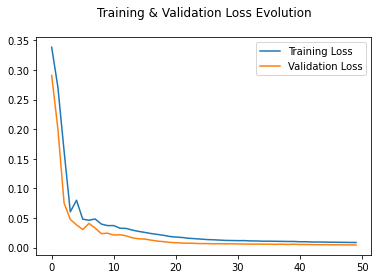

In [89]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

We'll test our models against both houses

Number of data points considered as anomalies (= activity) :  12040


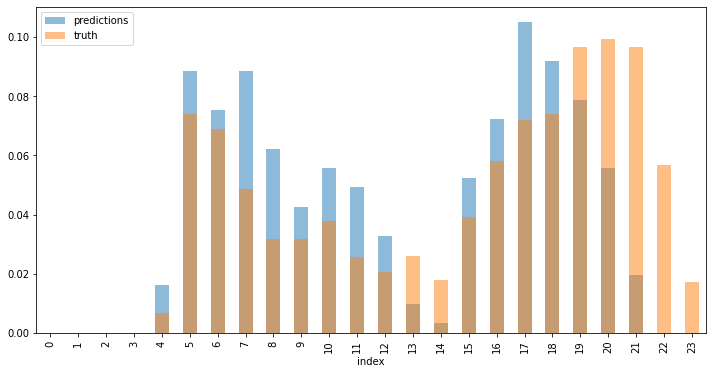

Score f_beta : 70.834%
Score accuracy : 71.244%


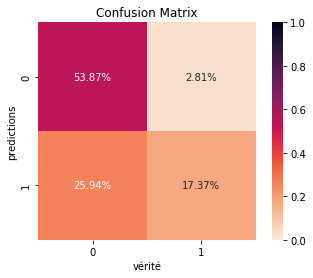

true positive rate: 73.81%, false positive rate: 2.63%


In [90]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h1)

Number of data points considered as anomalies (= activity) :  8360


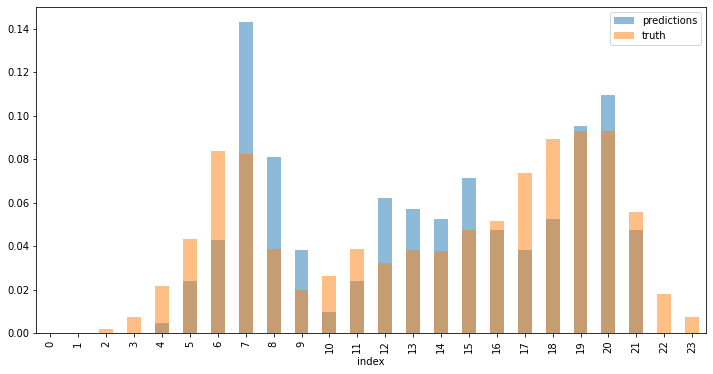

Score f_beta : 68.176%
Score accuracy : 69.337%


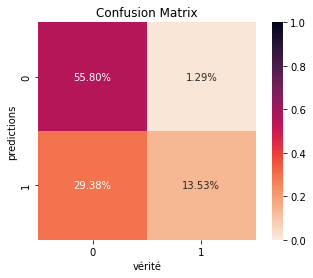

true positive rate: 48.72%, false positive rate: 0.00%


In [91]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h1)

### Fune-tine the model on house 2

Epoch 1/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 11/100
4/4 [=

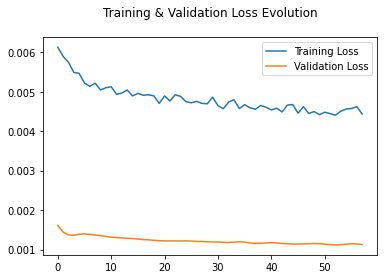

In [92]:
# on modifie la valeur du learning rate
K.set_value(model_h1.optimizer.learning_rate, LEARNING_RATE_FT)

# les layers entre LAYERS_FT[0] et LAYERS_FT[1] ne sont plus entrainables
if LAYERS_FT[0] and LAYERS_FT[1]:
    for layer in model_h1.layers[LAYERS_FT[0]:LAYERS_FT[1]+1]:
        layer.trainable = False

history = model_h1.fit(
    X_train_h2_ft,
    X_train_h2_ft,
    epochs=NITER_FT,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

Number of data points considered as anomalies (= activity) :  9720


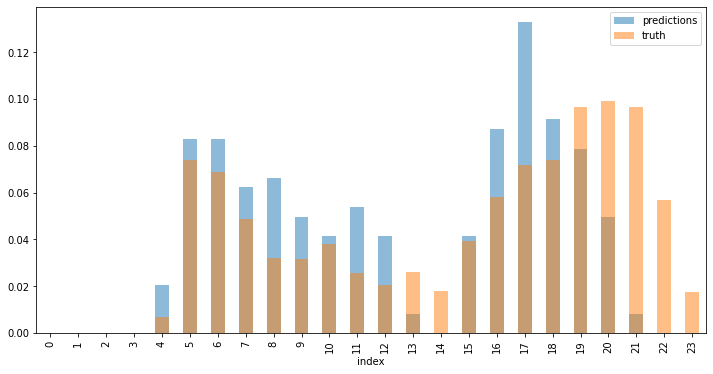

Score f_beta : 66.906%
Score accuracy : 68.332%


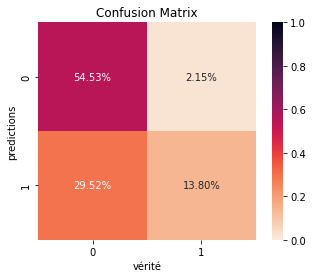

true positive rate: 64.29%, false positive rate: 0.00%


In [93]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h1)

Number of data points considered as anomalies (= activity) :  10240


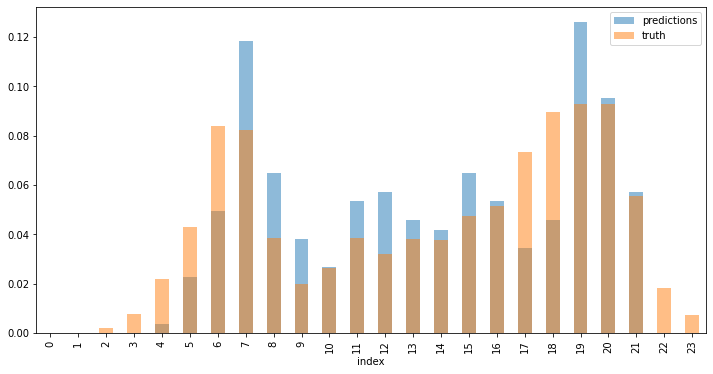

Score f_beta : 73.162%
Score accuracy : 72.971%


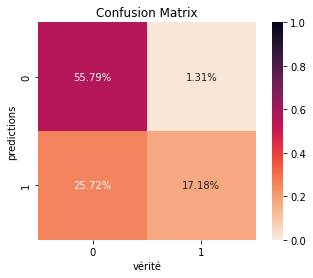

true positive rate: 58.97%, false positive rate: 0.00%


In [94]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h1)

## Fit a model on house 2

In [95]:
model_h2 = keras.Sequential(
    [
        layers.Input(shape=(X_train_h2.shape[1], X_train_h2.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
model_h2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
model_h2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 20, 32)            256       
                                                                 
 dropout_12 (Dropout)        (None, 20, 32)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 10, 16)            3600      
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 20, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_13 (Dropout)        (None, 20, 16)            0         
                                                                 
 conv1d_transpose_19 (Conv1D  (None, 40, 32)           3616      
 Transpose)                                           

### Train the model

Please note that we are using ``X_train`` as both the input and the target since this is a reconstruction model.

In [96]:
history = model_h2.fit(
    X_train_h2,
    X_train_h2,
    epochs=NITER,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
4/4 [==============================] - 1s 78ms/step - loss: 0.1186 - val_loss: 0.0942
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1022 - val_loss: 0.0772
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0812 - val_loss: 0.0534
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0523 - val_loss: 0.0241
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0236 - val_loss: 0.0137
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0240 - val_loss: 0.0195
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0207 - val_loss: 0.0107
Epoch 8/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0.0112
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0169 - val_loss: 0.0115
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0162 - val_loss: 0.0098
Epoch 11/50
4/4 [============

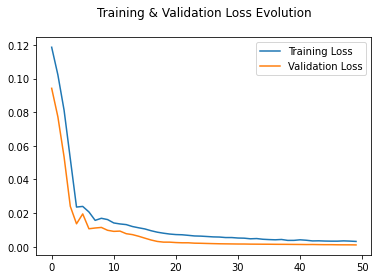

In [97]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

Number of data points considered as anomalies (= activity) :  6160


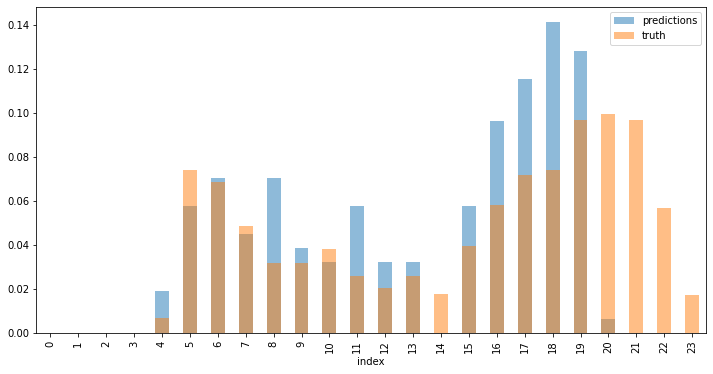

Score f_beta : 57.941%
Score accuracy : 63.253%


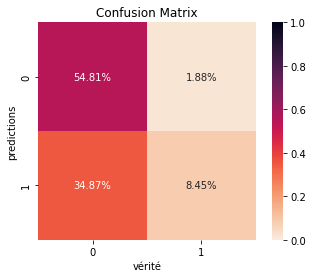

true positive rate: 40.48%, false positive rate: 0.00%


In [98]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h2)

Number of data points considered as anomalies (= activity) :  22440


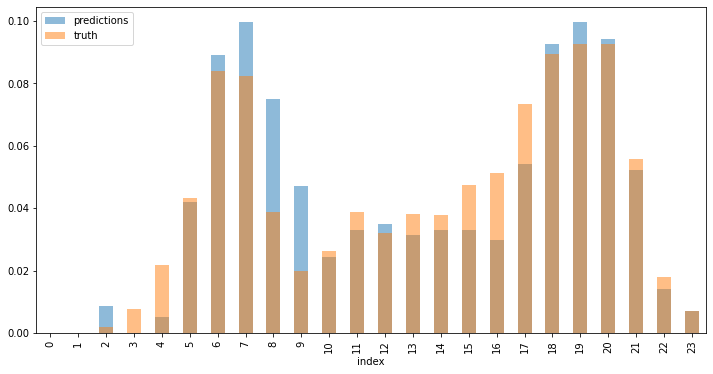

Score f_beta : 87.125%
Score accuracy : 87.279%


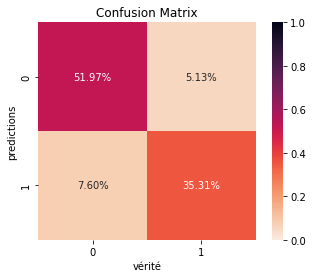

true positive rate: 76.92%, false positive rate: 3.23%


In [99]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h2)

### Fune-tine the model on house 1

Epoch 1/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0209 - val_loss: 0.0090
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0145 - val_loss: 0.0062
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0143 - val_loss: 0.0077
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0150 - val_loss: 0.0062
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0132 - val_loss: 0.0056
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0125 - val_loss: 0.0061
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0129 - val_loss: 0.0057
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.0052
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0120 - val_loss: 0.0051
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0050
Epoch 11/100
4/4 [=

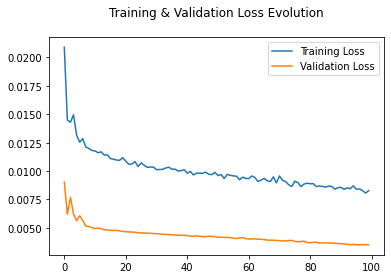

In [100]:
# on modifie la valeur du learning rate
K.set_value(model_h2.optimizer.learning_rate, LEARNING_RATE_FT)
# seules les layers entre LAYERS_FT[0] et LAYERS_FT[1] deviennent entrainable
for layer in model_h2.layers[LAYERS_FT[0]:LAYERS_FT[1]+1]:
    layer.trainable = False

history = model_h2.fit(
    X_train_h1_ft,
    X_train_h1_ft,
    epochs=NITER_FT,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

Number of data points considered as anomalies (= activity) :  8640


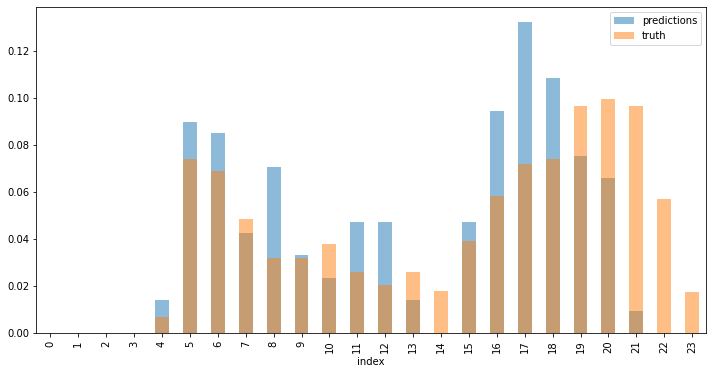

Score f_beta : 64.266%
Score accuracy : 66.645%


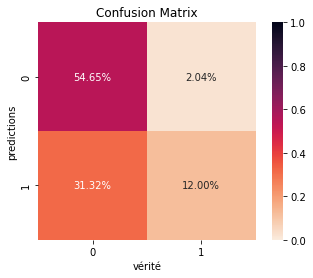

true positive rate: 52.38%, false positive rate: 0.00%


In [101]:
get_scores(X_train_h1, X_test_h1, y_test_h1, test_df_h1, model_h2)

Number of data points considered as anomalies (= activity) :  9480


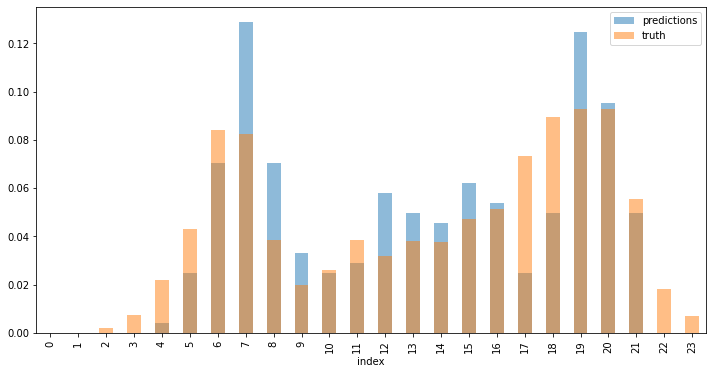

Score f_beta : 71.232%
Score accuracy : 71.489%


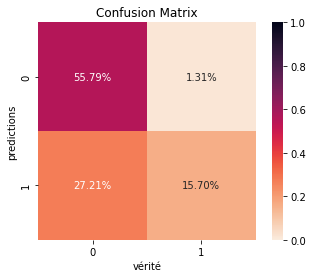

true positive rate: 56.41%, false positive rate: 0.00%


In [102]:
get_scores(X_train_h2, X_test_h2, y_test_h2, test_df_h2, model_h2)